## import libraries

In [37]:
import gym
import torch
import torch.nn as nn
env = gym.make('CartPole-v0')

In [38]:
class PolicyNetwork():
    def __init__(self, n_state, n_action, n_hidden=50, lr=0.001):
        self.model = nn.Sequential(
                        nn.Linear(n_state, n_hidden),
                        nn.ReLU(),
                        nn.Linear(n_hidden, n_action),
                        nn.Softmax(),
                        )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)
    

    def predict(self, s):
      return self.model(torch.Tensor(s))

    def update(self, returns, log_probs):
      policy_gradient = []
      for log_prob, Gt in zip(log_probs, returns):
        policy_gradient.append(-log_prob * Gt)
      loss = torch.stack(policy_gradient).sum()
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

    def get_action(self, s):
      probs = self.predict(s)
      action = torch.multinomial(probs, 1).item()
      log_prob = torch.log(probs[action])
      return action, log_prob


In [39]:
def reinforce(env, estimator, n_episode, gamma=1.0):
  for episode in range(n_episode):
    log_probs = []
    rewards = []
    state = env.reset()
    while True:
      action, log_prob = estimator.get_action(state)
      next_state, reward, is_done, _ = env.step(action)
      total_reward_episode[episode] += reward
      log_probs.append(log_prob)
      rewards.append(reward)
      if is_done:
        returns = []
        Gt = 0
        pw = 0
        for reward in rewards[::-1]:
          Gt += gamma ** pw * reward
          pw += 1
          returns.append(Gt)
        returns = returns[::-1]
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)
        estimator.update(returns, log_probs)
        print('Episode: {}, total reward: {}'.format(
        episode, total_reward_episode[episode]))
        break
      state = next_state


In [40]:
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_hidden = 128
lr = 0.003
policy_net = PolicyNetwork(n_state, n_action, n_hidden, lr)
gamma = 0.9

In [41]:
n_episode = 1000
total_reward_episode = [0] * n_episode
reinforce(env, policy_net, n_episode, gamma)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Episode: 0, total reward: 32.0
Episode: 1, total reward: 25.0
Episode: 2, total reward: 23.0
Episode: 3, total reward: 12.0
Episode: 4, total reward: 18.0
Episode: 5, total reward: 11.0
Episode: 6, total reward: 14.0
Episode: 7, total reward: 12.0
Episode: 8, total reward: 25.0
Episode: 9, total reward: 13.0
Episode: 10, total reward: 12.0
Episode: 11, total reward: 29.0
Episode: 12, total reward: 18.0
Episode: 13, total reward: 22.0
Episode: 14, total reward: 37.0
Episode: 15, total reward: 74.0
Episode: 16, total reward: 21.0
Episode: 17, total reward: 25.0
Episode: 18, total reward: 14.0
Episode: 19, total reward: 30.0
Episode: 20, total reward: 89.0
Episode: 21, total reward: 39.0
Episode: 22, total reward: 66.0
Episode: 23, total reward: 36.0
Episode: 24, total reward: 15.0
Episode: 25, total reward: 21.0
Episode: 26, total reward: 29.0
Episode: 27, total reward: 130.0
Episode: 28, total reward: 15.0
Episode: 29, total reward: 26.0
Episode: 30, total reward: 13.0
Episode: 31, tota

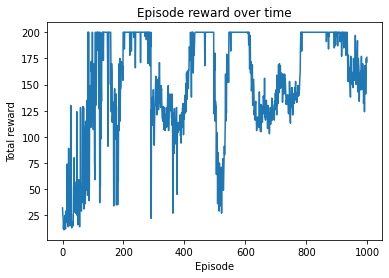

In [42]:
import matplotlib.pyplot as plt
plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()

## Helpful resources
[Policy-Gradient Methods](https://towardsdatascience.com/policy-gradient-methods-104c783251e0)
